In [1]:
!pip install blitz-bayesian-pytorch

     |████████████████████████████████| 51kB 2.8MB/s 


In [2]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from blitz.modules import BayesianLSTM
from blitz.utils import variational_estimator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
%matplotlib inline

from collections import deque

data = pd.read_excel('data_20y_v13.xlsx')
data

,id,version_id,itemplan_id,bi_brm,ra_rm,ei_erm,ei_elc,ei_eoh,ic_dlfc,ic_ohdfe,ic_ohdfd,ic_dlvc,ic_ohdvc,ic_idlc,ic_idohc,proq,proamt_unit,ic_arm,uc_srw,uc_dlc,uc_idlc,uc_idohc,uc_dohc
0,1,200001,3,17415549,0,46821054,0,0,5490412,280799,869822,0,2503700,930183,921941,2880,26470,81450058,52044552,5490412,930183,921941,2784499
1,2,200001,2,1526791,0,143292124,0,0,33871013,1732282,5366038,0,15445629,4334581,4296172,16639,21350,392674579,250909246,33871013,4334581,4296172,17177911
2,3,200001,1,130425628,0,142482613,0,0,2957785,151271,468589,0,1348789,387382,383949,1453,21850,33396537,21339553,2957785,387382,383949,1500060
3,4,200002,3,17413728,0,46824488,0,0,5490445,280798,869734,0,2503925,930100,921899,2880,26472,81193250,51881068,5490445,930100,921899,2784723
4,5,200002,2,1526579,0,143283554,0,0,33871697,1732316,5366085,0,15444518,4334860,4296863,16638,21348,391416771,250073131,33871697,4334860,4296863,17176834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
751,752,202011,2,1419495,0,133307026,0,0,31090290,1584338,4907445,0,14478737,4059699,4020106,15513,19923,365351650,233400954,31090290,4059699,4020106,16063075
752,753,202011,1,121215341,0,132505046,0,0,2696975,138658,428753,0,1264068,363035,361009,1353,20348,31134626,19840080,2696975,363035,361009,1402726
753,754,202012,3,16179768,0,43480202,0,0,5026669,256829,794854,0,2349548,872830,865901,2674,24578,76051720,48498141,5026669,872830,865901,2606377
754,755,202012,2,1414195,0,132823127,0,0,30975811,1578364,4889135,0,14424700,4044219,4005026,15456,19847,363957928,232505429,30975811,4044219,4005026,16003064


In [3]:
#독립변수 3 항목 - 고정비, 변동비, 재료비 -> 종속변수 1 항목 - 매출액
data['x1'] = data['ic_dlvc'] + data['ic_ohdvc'] + data['ic_idlc'] + data['ic_idohc'] #변동비4개/
data['x2'] =  data['ic_dlfc'] + data['ic_ohdfe'] + data['ic_ohdfd'] #고정비3개
data['x3'] = data['uc_srw'] # 당기 사용 재료비
data['y'] = data['proq'] * data['proamt_unit'] # 매출액
df = data[['version_id'	,'itemplan_id','x1','x2','x3','y']]
#
df_new = df.groupby(['version_id'], as_index=False)['x1','x2','x3','y'].agg('sum')
#
from datetime import datetime

date = df_new['version_id'].astype(str)
len(date)
kdate = [datetime.strptime(d, '%Y%m') for d in date]
df_new['version_id'] = kdate
df_new

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


,version_id,x1,x2,x3,y
0,2000-01-01,30552326,51188011,324293351,463224300
1,2000-02-01,30552194,51188119,323222895,463176887
2,2000-03-01,30553722,51142137,323584299,463079531
3,2000-04-01,30576689,51205260,324966725,464499530
4,2000-05-01,30553298,51203415,324977876,462641622
...,...,...,...,...,...
247,2020-08-01,28972210,47480513,305389197,411981701
248,2020-09-01,28865451,47300603,304213592,408942484
249,2020-10-01,28757559,47123757,303056582,405887681
250,2020-11-01,28650608,46948107,301926437,402843348


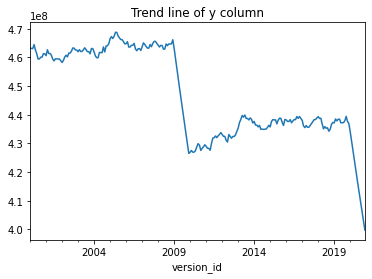

In [4]:
new_plot = df_new.set_index('version_id')
new_plot['y'].plot(title = 'Trend line of y column')

In [5]:
df_new['x1']

0      30552326
1      30552194
2      30553722
3      30576689
4      30553298
         ...   
247    28972210
248    28865451
249    28757559
250    28650608
251    28542779
Name: x1, Length: 252, dtype: int64

In [6]:
scaler = StandardScaler()
ycol = ["y"] # 종속변수
xcol = ['x1', 'x2', 'x3','y'] # 전체 열
xxcol = ['x1', 'x2', 'x3'] # 독립변수
y_prices_unscaled = df_new["y"]
df_new[xxcol] = scaler.fit_transform(df_new[xxcol]) #  x 정규화 시킨거 변경해줌
y_scaler = StandardScaler()
df_new[ycol] = y_scaler.fit_transform(df_new[ycol]) #  y 정규화 시킨거 변경해줌


In [7]:
df_new

,version_id,x1,x2,x3,y
0,2000-01-01,1.049749,1.003193,0.741816,1.067325
1,2000-02-01,1.049542,1.003283,0.579884,1.064255
2,2000-03-01,1.051944,0.965035,0.634555,1.057952
3,2000-04-01,1.088049,1.017541,0.843680,1.149888
4,2000-05-01,1.051277,1.016006,0.845367,1.029600
...,...,...,...,...,...
247,2020-08-01,-1.434271,-2.080739,-2.117891,-2.250303
248,2020-09-01,-1.602102,-2.230390,-2.295730,-2.447073
249,2020-10-01,-1.771714,-2.377492,-2.470755,-2.644852
250,2020-11-01,-1.939846,-2.523599,-2.641717,-2.841953


In [19]:
@variational_estimator
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.lstm_1 = BayesianLSTM(3, 10)
        self.linear = nn.Linear(10, 1)
            
    def forward(self, x):
        x_, _ = self.lstm_1(x)
        
        #gathering only the latent end-of-sequence for the linear layer
        x_ = x_[:, -1, :]
        x_ = self.linear(x_)
        return x_

In [20]:
df_new[xxcol].values

array([[ 1.04974935e+00,  1.00319309e+00,  7.41816004e-01],
       [ 1.04954184e+00,  1.00328292e+00,  5.79883837e-01],
       [ 1.05194393e+00,  9.65034658e-01,  6.34554867e-01],
       [ 1.08804920e+00,  1.01754097e+00,  8.43679986e-01],
       [ 1.05127738e+00,  1.01600628e+00,  8.45366842e-01],
       [ 9.79645368e-01,  1.06635405e+00,  7.38812458e-01],
       [ 9.40443165e-01,  1.10296947e+00,  6.33947048e-01],
       [ 9.40864474e-01,  1.07653290e+00,  7.43821292e-01],
       [ 8.72854461e-01,  1.09609457e+00,  8.48968223e-01],
       [ 8.37118628e-01,  1.07282636e+00,  7.96455569e-01],
       [ 8.38242644e-01,  1.14695390e+00,  8.02929189e-01],
       [ 8.74278738e-01,  1.09983438e+00,  7.51581195e-01],
       [ 8.41806480e-01,  1.16956248e+00,  8.02989245e-01],
       [ 8.41674428e-01,  1.11729157e+00,  7.49894187e-01],
       [ 8.77303362e-01,  1.13555062e+00,  8.00993487e-01],
       [ 8.76537774e-01,  1.16021544e+00,  6.96717289e-01],
       [ 8.41198097e-01,  1.08811834e+00

In [21]:
#Xs 전처리 함수
def create_timestamps_ds(series, 
                         timestep_size=3):
    time_stamps = []
    aux_deque = deque(maxlen=timestep_size)
    
    #starting the timestep deque
    for i in range(timestep_size):
        aux_deque.append(0)
    
    #feed the timestamps list
    for i in range(len(series)):
      for j in range(3):
        aux_deque.append([series[i][j]])
      time_stamps.append(list(aux_deque))
    
    #assert len(time_stamps) == len(labels), "Something went wrong"
    
    #torch-tensoring it
    features = torch.tensor(time_stamps).float()
   
    
    return features
#Split하고 train이랑 test랑 나눠주기
Xs = create_timestamps_ds(df_new[xxcol].values)
ys = torch.tensor(df_new[ycol].values).float()
X_train, X_test, y_train, y_test = train_test_split(Xs,
                                                    ys,
                                                    test_size=.25,
                                                    random_state=42,
                                                    shuffle=False)

In [22]:

ds = torch.utils.data.TensorDataset(X_train, y_train)
dataloader_train = torch.utils.data.DataLoader(ds, batch_size=30, shuffle=True)
net = NN()
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [ ]:
for i in enumerate(dataloader_train):
  print(i)


In [23]:
#Training Part

iteration = 0
for epoch in range(450):
    for i, (datapoints, labels) in enumerate(dataloader_train):
        optimizer.zero_grad()
        
        #cost계산
        loss = net.sample_elbo(inputs=datapoints,
                               labels=labels,
                               criterion=criterion,
                               sample_nbr=3
                               )
        #cost로 H 개선
        loss.backward()
        optimizer.step()
        
#         iteration += 1
    if epoch % 50 ==0:
        preds_test = net(X_test)[:,0].unsqueeze(1)
        loss_test = criterion(preds_test, y_test)
        print("Epoch: {} Val-loss: {:.4f}".format(str(epoch), loss_test))

RuntimeError: ignored

In [60]:
#pred_unscaled
original = y_prices_unscaled[:]
original

0      463224300
1      463176887
2      463079531
3      464499530
4      462641622
         ...    
247    411981701
248    408942484
249    405887681
250    402843348
251    399800764
Name: y, Length: 252, dtype: int64

,version_id,x1,x2,x3,y
0,2000-01-01,1.049749,1.003193,0.741816,1.067325
1,2000-02-01,1.049542,1.003283,0.579884,1.064255
2,2000-03-01,1.051944,0.965035,0.634555,1.057952
3,2000-04-01,1.088049,1.017541,0.843680,1.149888
4,2000-05-01,1.051277,1.016006,0.845367,1.029600
...,...,...,...,...,...
247,2020-08-01,-1.434271,-2.080739,-2.117891,-2.250303
248,2020-09-01,-1.602102,-2.230390,-2.295730,-2.447073
249,2020-10-01,-1.771714,-2.377492,-2.470755,-2.644852
250,2020-11-01,-1.939846,-2.523599,-2.641717,-2.841953


In [64]:

df_pred = pd.DataFrame(original)
df_pred["Date"] = df_new.version_id
df_new["Date"] = pd.to_datetime(df_pred["Date"])
df_pred = df_pred.reset_index()
#df_pred = df_pred.set_index('Date')

In [65]:
def pred_price_future(X_test,future_length,sample_nbr=10,TIME_STEPS=None):
    
    #sorry for that, window_size is a global variable, and so are X_train and Xs
    global X_train
    global Xs
    
    #creating auxiliar variables for future prediction
    preds_test = []
    test_begin = X_test[0:1, :, :]
    test_deque = deque(test_begin[0,:,0].tolist(), maxlen=3)

    idx_pred = np.arange(len(X_train), len(Xs))
    
    #predict it and append to list
    for i in range(len(X_test)):
        #print(i)
#         as_net_input = torch.tensor(test_deque).unsqueeze(0).unsqueeze(2)
        as_net_input = X_test[[i],:,:]
        pred = [net(as_net_input).cpu().item() for i in range(sample_nbr)]
        
        
        test_deque.append(torch.tensor(pred).mean().cpu().item())
        preds_test.append(pred)
        
        if i % future_length == 0:
            #our inptus become the i index of our X_test
            #That tweak just helps us with shape issues
            test_begin = X_test[i:i+1, :, :]
            test_deque = deque(test_begin[0,:,0].tolist(), maxlen=3)

    #preds_test = np.array(preds_test).reshape(-1, 1)
    #preds_test_unscaled = scaler.inverse_transform(preds_test)
    
    return idx_pred, preds_test

In [66]:
def get_confidence_intervals(preds_test, ci_multiplier,y_scaler):
    
    
    preds_test = torch.tensor(preds_test)
    
    pred_mean = preds_test.mean(1)
    pred_std = preds_test.std(1).detach().cpu().numpy()

    pred_std = torch.tensor((pred_std))
    #print(pred_std)
    
    upper_bound = pred_mean + (pred_std * ci_multiplier)
    lower_bound = pred_mean - (pred_std * ci_multiplier)
    #gather unscaled confidence intervals

    pred_mean_final = pred_mean.unsqueeze(1).detach().cpu().numpy()
    pred_mean_unscaled = y_scaler.inverse_transform(pred_mean_final)

    upper_bound_unscaled = upper_bound.unsqueeze(1).detach().cpu().numpy()
    upper_bound_unscaled = y_scaler.inverse_transform(upper_bound_unscaled)
    
    lower_bound_unscaled = lower_bound.unsqueeze(1).detach().cpu().numpy()
    lower_bound_unscaled = y_scaler.inverse_transform(lower_bound_unscaled)
    
    return pred_mean_unscaled, upper_bound_unscaled, lower_bound_unscaled

0.0 our predictions are in our confidence interval


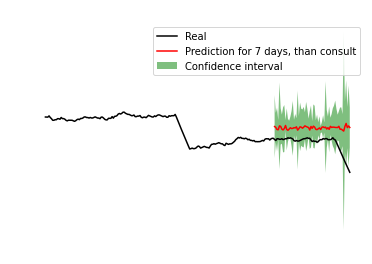

In [68]:
future_length=7
sample_nbr=3
ci_multiplier=10
idx_pred, preds_test = pred_price_future(X_test, future_length, sample_nbr, TIME_STEPS=3)
pred_mean_unscaled, upper_bound_unscaled, lower_bound_unscaled = get_confidence_intervals(preds_test,ci_multiplier,y_scaler)
y = df_new.iloc[idx_pred,:]["y"].values.reshape(-1,1)
under_upper = upper_bound_unscaled > y
over_lower = lower_bound_unscaled < y
total = (under_upper == over_lower)

print("{} our predictions are in our confidence interval".format(np.mean(total)))
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}

plt.rcParams.update(params)

plt.title("Manufacturing sales prices", color="white")

plt.plot(df_pred.index,
         df_pred.y,
         color='black',
         label="Real")

plt.plot(idx_pred,
         pred_mean_unscaled,
         label="Prediction for {} days, than consult".format(future_length),
         color="red")

plt.fill_between(x=idx_pred,
                 y1=upper_bound_unscaled[:,0],
                 y2=lower_bound_unscaled[:,0],
                 facecolor='green',
                 label="Confidence interval",
                 alpha=0.5)

plt.legend()

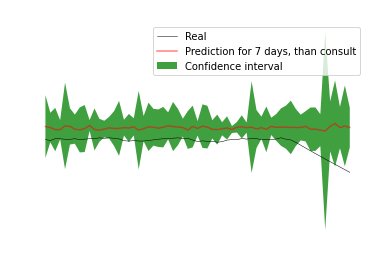

In [70]:
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w"}
plt.rcParams.update(params)

plt.title("IBM Stock prices", color="white")


plt.fill_between(x=idx_pred,
                 y1=upper_bound_unscaled[:,0],
                 y2=lower_bound_unscaled[:,0],
                 facecolor='green',
                 label="Confidence interval",
                 alpha=0.75)

plt.plot(idx_pred,
         df_pred.y[-len(pred_mean_unscaled):],
         label="Real",
         alpha=1,
         color='black',
         linewidth=0.5)

plt.plot(idx_pred,
         pred_mean_unscaled,
         label="Prediction for {} days, than consult".format(future_length),
         color="red",
         alpha=0.5)

plt.legend()